In [90]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [91]:

# Configurar TensorFlow para usar GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Usando GPU para treinamento e inferência.")

# Caminho das pastas
# TRAINING_DIR = "./faces"
TRAINING_DIR = "./faces"
TRAINING_DIR = os.path.expanduser(TRAINING_DIR)

Usando GPU para treinamento e inferência.


In [92]:


# Função para carregar e redimensionar imagens
def load_images_and_labels(base_dir, target_size=(160, 160)):
    images = []
    labels = []
    for label in os.listdir(base_dir):
        label_path = os.path.join(base_dir, label)
        if os.path.isdir(label_path):
            for image_file in os.listdir(label_path):
                image_path = os.path.join(label_path, image_file)
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.resize(image, target_size)
                    images.append(image)
                    labels.append(label)
    return np.array(images), np.array(labels)


In [93]:

# Carregar imagens e labels
images, labels = load_images_and_labels(TRAINING_DIR)

# Codificar labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.3, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=4,
    width_shift_range=0.01,
    height_shift_range=0.01,
    horizontal_flip=False
)
datagen.fit(X_train)


Found 45 images belonging to 6 classes.
Mostrando imagens do lote de treinamento


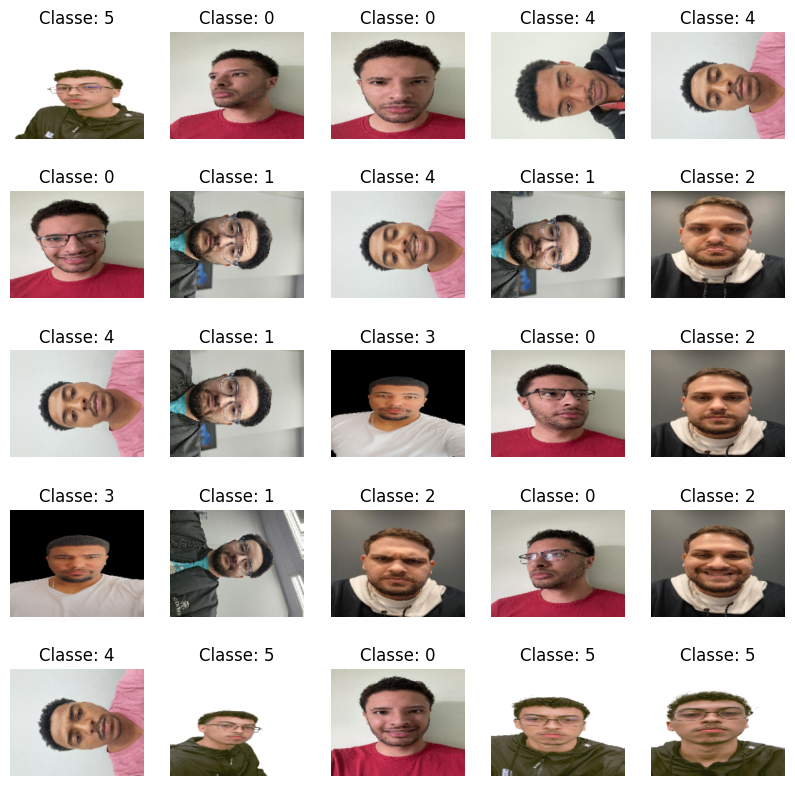

In [94]:
import matplotlib.pyplot as plt

batch_size = 25
img_width, img_height = (160, 200)

# Função para plotar as imagens e rótulos
def plot_images(images, labels, batch_size):
    plt.figure(figsize=(10, 10))
    for i in range(batch_size):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i])
        plt.title(f"Classe: {labels[i].argmax()}")
        plt.axis('off')
    plt.show()

train_generator_faces = datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)


images_train, labels_train = next(train_generator_faces)

# Exibe as imagens de treino
print("Mostrando imagens do lote de treinamento")
plot_images(images_train, labels_train, batch_size)


In [95]:

# Modelo base (MobileNetV2)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(160, 160, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, kernel_initializer="he_normal")(x)  # Camada densa
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)

x = Dense(256, kernel_initializer="he_normal")(x)  # Segunda camada densa
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)

x = Dense(256, kernel_initializer="he_normal")(x)  # Segunda camada densa
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)

x = Dense(128, kernel_initializer="he_normal")(x)  # Terceira camada densa
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)

x = Dense(128, kernel_initializer="he_normal")(x)  # Terceira camada densa
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)

x = Dense(64, kernel_initializer="he_normal")(x)  # Quarta camada densa
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)

x = Dense(64, kernel_initializer="he_normal")(x)  # Quarta camada densa
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)

x = Dense(32, kernel_initializer="he_normal")(x)  # Segunda camada densa
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)

x = Dense(32, kernel_initializer="he_normal")(x)  # Segunda camada densa
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)

x = Dense(16, kernel_initializer="he_normal")(x)  # Terceira camada densa
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)

x = Dense(16, kernel_initializer="he_normal")(x)  # Terceira camada densa
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)

x = Dense(8, kernel_initializer="he_normal")(x)  # Quarta camada densa
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)

x = Dense(8, kernel_initializer="he_normal")(x)  # Quarta camada densa
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)


output = Dense(len(np.unique(labels_encoded)), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

# Congelar camadas do modelo base
for layer in base_model.layers:
    layer.trainable = False

# Compilar modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Treinar modelo
print("Treinando modelo...")
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test / 255.0, y_test),
    epochs=120,
    verbose=1
)


Treinando modelo...
Epoch 1/120


/home/vinicius/Documents/Aulas/ProcessamentoImagem/face_detection/face_detection/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step - accuracy: 0.2581 - loss: 2.0117 - val_accuracy: 0.1429 - val_loss: 1.7764
Epoch 2/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.1613 - loss: 2.2262 - val_accuracy: 0.0714 - val_loss: 1.7780
Epoch 3/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.2258 - loss: 2.1976 - val_accuracy: 0.2143 - val_loss: 1.7729
Epoch 4/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.2258 - loss: 2.0783 - val_accuracy: 0.2143 - val_loss: 1.7661
Epoch 5/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.3226 - loss: 1.8483 - val_accuracy: 0.2143 - val_loss: 1.7616
Epoch 6/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.1613 - loss: 2.0006 - val_accuracy: 0.2143 - val_loss: 1.7623
Epoch 7/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.1290 - loss: 1.8755 - val_accuracy: 0.1429 - val_loss: 1.7664
Epoch 8/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.2903 - loss: 1.8704 - val_accuracy: 0.2143 - val_loss: 1.76

In [96]:

# Função para inferência e reconhecimento facial
def recognize_faces(test_image_path):
    test_image = cv2.imread(test_image_path)
    test_image_resized = cv2.resize(test_image, (160, 160)) / 255.0
    test_image_expanded = np.expand_dims(test_image_resized, axis=0)
    predictions = model.predict(test_image_expanded)
    predicted_class = np.argmax(predictions)

    if np.max(predictions) > 0.6:  # Threshold de confiança
        name = label_encoder.inverse_transform([predicted_class])[0]
    else:
        name = "Não reconhecido"

    # Exibir a imagem com a predição
    plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Reconhecido como: {name}")
    plt.axis("off")
    plt.show()


In [97]:
import os

def test_faces_in_directory(test_dir):
    """
    Varre um diretório e subdiretórios para testar imagens de rostos.
    
    Args:
        test_dir (str): Caminho para o diretório contendo as imagens de teste.
    """
    test_dir = os.path.expanduser(test_dir)  # Expande ~ para o diretório do usuário
    for root, _, files in os.walk(test_dir):
        for file in files:
            if file.lower().endswith((".png", ".jpg", ".jpeg")):  # Verifica extensões de imagem
                test_image_path = os.path.join(root, file)
                print(f"Testando: {test_image_path}")
                recognize_faces(test_image_path)


Testando: ./faces-teste/Araujo/20241113_212103.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


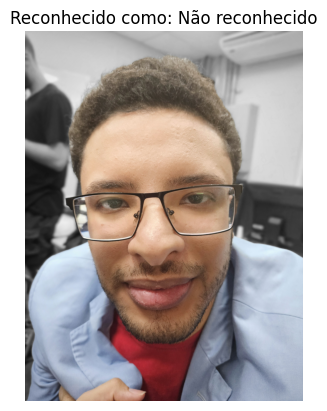

Testando: ./faces-teste/Giovanelli/20241113_212124.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


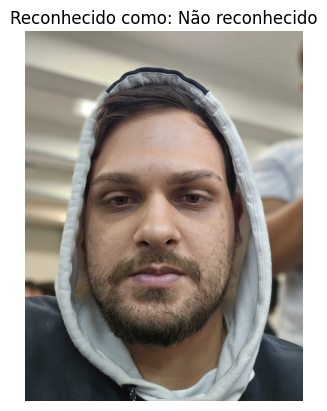

Testando: ./faces-teste/Bodruch/20241113_211211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


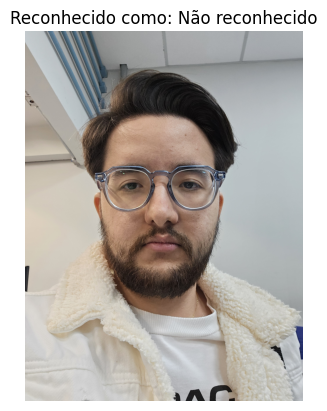

Testando: ./faces-teste/Vinicin/20241113_212047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


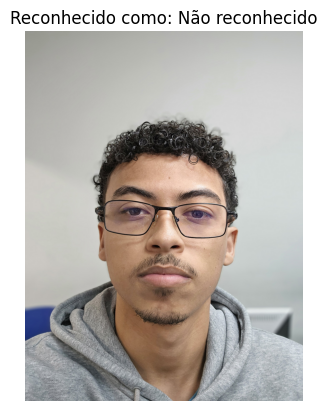

Testando: ./faces-teste/Nery/20241113_212116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


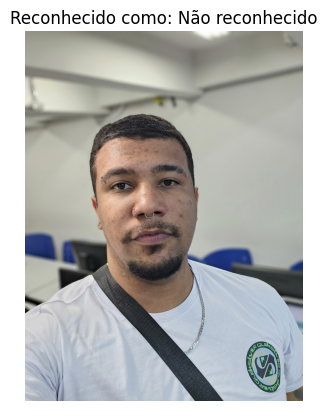

Testando: ./faces-teste/Thiago/20241113_212136.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


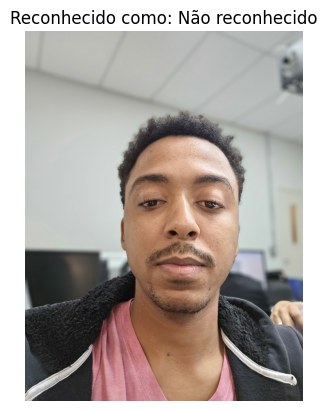

In [98]:

# Caminho para o diretório de teste
TEST_DIR = "./faces-teste"
test_faces_in_directory(TEST_DIR)
